<a href="https://colab.research.google.com/github/rahafabumwise/coffee-machine-python/blob/main/notebooks/step_by_step_LightGBM_classification_tsk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


In [3]:
import pandas as pd
clf_data = pd.read_parquet("/content/drive/MyDrive/instacart_project/data/classification/clf_df.parquet")

In [ ]:
clf_data.head()

,user_id,product_id,prior_purchase_count_uxp,days_since_last,reorder_prob_userxprod,user_total_orders,user_average_basket,user_reorder_ratio,user_mean_days_between_order,user_last_interorder_gap,product_total_purchase,product_reorder_ratio,product_avg_cart_pos,product_pop_overtime,reorder,streak,last_order_contains_product
0,202279,33120,5,0.0,0.800000,8,11.25,0.477778,21.862499,30.0,19400,0.708454,6.816959,18.204227,1,1,1
1,202279,28985,5,54.0,0.800000,8,11.25,0.477778,21.862499,30.0,67449,0.694465,7.501683,15.959421,0,0,0
2,202279,9327,1,123.0,0.000000,8,11.25,0.477778,21.862499,30.0,6299,0.157962,9.943166,14.909350,0,0,0
3,202279,45918,5,30.0,0.800000,8,11.25,0.477778,21.862499,30.0,744,0.272849,8.444893,17.795698,0,0,0
4,202279,30035,3,30.0,0.666667,8,11.25,0.477778,21.862499,30.0,569,0.507909,8.481546,19.773287,0,0,0


#Split data

first split my data to train and test

In [4]:
user_label = clf_data.groupby("user_id")["reorder"].max().astype(int)

In [5]:
from sklearn.model_selection import train_test_split

users = user_label.index.to_numpy()
y_user = user_label.to_numpy()

train_users, test_users = train_test_split(
    users,
    test_size=0.2,
    random_state=42,
    stratify=y_user
)

In [6]:
cl_train_df = clf_data[clf_data["user_id"].isin(train_users)].copy()
cl_test_df  = clf_data[clf_data["user_id"].isin(test_users)].copy()

In [7]:
# 1) No overlap in users
assert set(cl_train_df["user_id"]).isdisjoint(set(cl_test_df["user_id"]))

# 2) Distribution check (row-level)
print("Row reorder rate - train:", cl_train_df["reorder"].mean())
print("Row reorder rate - test :", cl_test_df["reorder"].mean())

# 3) Distribution check (user-level)
print("User reorder rate - train:", user_label.loc[train_users].mean())
print("User reorder rate - test :", user_label.loc[test_users].mean())

Row reorder rate - train: 0.06228055421132008
Row reorder rate - test : 0.062279545787892056
User reorder rate - train: 0.5945734601465748
User reorder rate - test : 0.594588041317104


now another split for train data for more friendly ram work

In [8]:
user_label = cl_train_df.groupby("user_id")["reorder"].max().astype(int)
from sklearn.model_selection import train_test_split

users = user_label.index.to_numpy()
y_user = user_label.to_numpy()

sample, _= train_test_split(
    users,
    train_size=0.1,
    random_state=42,
    stratify=y_user
)

In [9]:
sample_df = cl_train_df[cl_train_df["user_id"].isin(sample)].copy()

In [ ]:
sample_df.shape

(1071950, 17)

In [ ]:
sample_df.head()

,user_id,product_id,prior_purchase_count_uxp,days_since_last,reorder_prob_userxprod,user_total_orders,user_average_basket,user_reorder_ratio,user_mean_days_between_order,user_last_interorder_gap,product_total_purchase,product_reorder_ratio,product_avg_cart_pos,product_pop_overtime,reorder,streak,last_order_contains_product
216,193635,40078,1,48.0,0.0,26,6.730769,0.52,7.362069,8.0,3573,0.492583,10.029107,17.527569,0,0,0
217,193635,9065,2,21.0,0.5,26,6.730769,0.52,7.362069,8.0,1944,0.448560,8.731996,14.029321,0,0,0
218,193635,46175,2,21.0,0.5,26,6.730769,0.52,7.362069,8.0,5928,0.447031,8.429150,12.042004,0,0,0
342,39630,20915,1,0.0,0.0,14,7.142857,0.19,4.258065,4.0,743,0.627187,7.717362,13.932705,0,1,1
343,39630,21949,1,0.0,0.0,14,7.142857,0.19,4.258065,4.0,1531,0.602874,10.124755,19.412149,0,1,1


In [ ]:
print("sample_df shape:", sample_df.shape)
print("unique users in sample_df:", sample_df["user_id"].nunique())
print("expected users in sample:", len(sample))

# sanity: every sampled user exists in sample_df
missing = set(sample) - set(sample_df["user_id"].unique())
print("missing sampled users:", len(missing))


sample_df shape: (1071950, 17)
unique users in sample_df: 16496
expected users in sample: 16496
missing sampled users: 0


All experiments were conducted on a user-stratified development sample derived exclusively from the training set. Labels, feature distributions, and class prevalence were validated against the full training data before model tuning.

#Step1-Baseline Model

In [77]:
TARGET = "reorder"
GROUP  = "user_id"

y_sample = sample_df[TARGET].astype(int)
groups = sample_df[GROUP]

X_sample = sample_df.drop(["user_id", "product_id", TARGET], axis=1)

print("X:", X_sample.shape, "y:", y_sample.shape, "groups:", groups.nunique())
print("positive rate:", y_sample.mean())

X: (1071950, 14) y: (1071950,) groups: 16496
positive rate: 0.061565371519193994


In [11]:
import lightgbm as lgb

lgbm_baseline = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)


In [ ]:
from sklearn.model_selection import GroupKFold
import numpy as np
def get_oof_proba_lgbm(model, X, y, groups, n_splits=3):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)

    for tr_idx, va_idx in gkf.split(X, y, groups):
        model.fit(X.iloc[tr_idx], y.iloc[tr_idx])
        oof[va_idx] = model.predict_proba(X.iloc[va_idx])[:, 1]

    return oof


In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score
oof_lgbm = get_oof_proba_lgbm(
    lgbm_baseline,
    X_sample,
    y_sample,
    groups,
    n_splits=3
)

print("LGBM baseline AUC:", roc_auc_score(y_sample, oof_lgbm))
print("LGBM baseline AP :", average_precision_score(y_sample, oof_lgbm))


[LightGBM] [Info] Number of positive: 44123, number of negative: 670510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 714633, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061742 -> initscore=-2.721057
[LightGBM] [Info] Start training from score -2.721057
[LightGBM] [Info] Number of positive: 43788, number of negative: 670845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 714633, number of used features: 14
[LightGBM] [In

#Step2-Imbalance-aware LightGBM with Early Stopping (Grouped OOF)

In [12]:
from sklearn.model_selection import GroupKFold
import numpy as np
import lightgbm as lgb

def get_oof_proba_lgbm_step2(base_model, X, y, groups, n_splits=3,
                            early_stopping_rounds=100):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)

    base_params = base_model.get_params()

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups), start=1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        # (1) fold-wise imbalance handling
        pos = int(y_tr.sum())
        neg = int(len(y_tr) - pos)
        spw = neg / max(pos, 1)

        # create a fresh model per fold (important)
        model = lgb.LGBMClassifier(**base_params, scale_pos_weight=spw)

        # (2) early stopping on the validation fold
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="auc",
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)]
        )

        # use best_iteration_ (from early stopping)
        oof[va_idx] = model.predict_proba(X_va, num_iteration=model.best_iteration_)[:, 1]

        print(f"Fold {fold}: scale_pos_weight={spw:.2f}, best_iter={model.best_iteration_}")

    return oof


In [13]:
oof_lgbm_step2 = get_oof_proba_lgbm_step2(
    lgbm_baseline,
    X_sample,
    y_sample,
    groups,
    n_splits=3,
    early_stopping_rounds=100
)


[LightGBM] [Info] Number of positive: 44123, number of negative: 670510
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2330
[LightGBM] [Info] Number of data points in the train set: 714633, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.061742 -> initscore=-2.721057
[LightGBM] [Info] Start training from score -2.721057
Fold 1: scale_pos_weight=15.20, best_iter=1
[LightGBM] [Info] Number of positive: 43788, number of negative: 670845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 714633

In [14]:
from sklearn.metrics import roc_auc_score, average_precision_score

print("LGBM Step 2 OOF AUC:", roc_auc_score(y_sample, oof_lgbm_step2))
print("LGBM Step 2 OOF AP :", average_precision_score(y_sample, oof_lgbm_step2))


LGBM Step 2 OOF AUC: 0.8015753150290046
LGBM Step 2 OOF AP : 0.22538343108437991


it is lower than our baseline, so we want to detect which one cause the problem

In [15]:
from sklearn.metrics import precision_recall_curve
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_sample, oof_lgbm_step2)
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

best_i = int(np.argmax(f1))
best_thr = float(thresholds[best_i])
best_f1 = float(f1[best_i])

print("Best OOF threshold:", best_thr)
print("Best OOF F1:", best_f1)


Best OOF threshold: 0.10459483268939233
Best OOF F1: 0.3124649057941794


##step2A-Early stopping (no imbalance handling yet)

In [16]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score


In [17]:
def oof_lgb_earlystop_only(X, y, groups, n_splits=3, num_boost_round=5000, early_stopping_rounds=200):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)

    params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "verbosity": -1,
        "seed": 42
    }

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)]
        )

        best_iter = model.best_iteration
        oof[va_idx] = model.predict(X_va, num_iteration=best_iter)

        print(f"Fold {fold}: best_iter={best_iter}")

    return oof


In [18]:
oof_early = oof_lgb_earlystop_only(X_sample, y_sample, groups, n_splits=3)
print("OOF AUC:", roc_auc_score(y_sample, oof_early))
print("OOF AP :", average_precision_score(y_sample, oof_early))


Fold 1: best_iter=81
Fold 2: best_iter=123
Fold 3: best_iter=105
OOF AUC: 0.8157955537739652
OOF AP : 0.2563917608131363


Conclusion:

✅ Early stopping is working correctly and improves generalization under user-grouped evaluation.

✅ The earlier Step 2 failure was not because “weights are bad” — it was because training was effectively stopping at 1 tree (severe underfitting).

✅ We fixed the “best_iter = 1” bug/issue by switching to a reliable early-stopping setup (lgb.train).
Now we can safely test weighting.


##Step 2B — Early-stopped LightGBM with Imbalance Weighting (Grouped OOF)

In [19]:
def oof_lgb_earlystop_plus_weight(X, y, groups, n_splits=3, num_boost_round=5000, early_stopping_rounds=200):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)

    base_params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "verbosity": -1,
        "seed": 42
    }

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx].astype(int)
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx].astype(int)

        # fold-wise scale_pos_weight = neg/pos
        pos = int(y_tr.sum())
        neg = int(len(y_tr) - pos)
        spw = neg / max(pos, 1)

        params = dict(base_params)
        params["scale_pos_weight"] = spw

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)]
        )

        best_iter = model.best_iteration
        oof[va_idx] = model.predict(X_va, num_iteration=best_iter)

        print(f"Fold {fold}: spw={spw:.2f}, best_iter={best_iter}")

    return oof


In [20]:
oof_2b = oof_lgb_earlystop_plus_weight(X_sample, y_sample, groups, n_splits=3)

print("Step 2B OOF AUC:", roc_auc_score(y_sample, oof_2b))
print("Step 2B OOF AP :", average_precision_score(y_sample, oof_2b))


Fold 1: spw=15.20, best_iter=67
Fold 2: spw=15.32, best_iter=81
Fold 3: spw=15.21, best_iter=85
Step 2B OOF AUC: 0.8160249488069287
Step 2B OOF AP : 0.25540577238039774


Although the dataset is highly imbalanced (reorder rate ≈ 6%), explicit class weighting using scale_pos_weight did not improve Average Precision under grouped out-of-fold evaluation. Similar behavior was observed in both Logistic Regression and LightGBM models, suggesting that the engineered features already provide sufficient class separation. In contrast, early stopping consistently improved generalization performance. Therefore, we retained the early-stopped, unweighted LightGBM configuration for subsequent tuning and final evaluation.

##Step2C-Threshold Selection from OOF (F1) for the Chosen Step 2 Model

In [21]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_sample, oof_early)

# thresholds has length = len(precision)-1
f1 = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)

best_i = int(np.argmax(f1))
best_thr = float(thresholds[best_i])
best_f1 = float(f1[best_i])

print("Step 2C (using Step 2A OOF preds)")
print("Best OOF threshold:", best_thr)
print("Best OOF F1:", best_f1)
print("Precision at best thr:", float(precision[best_i]))
print("Recall at best thr   :", float(recall[best_i]))


Step 2C (using Step 2A OOF preds)
Best OOF threshold: 0.15900837813819962
Best OOF F1: 0.32973121453112403
Precision at best thr: 0.2683810937321612
Recall at best thr   : 0.4274414728388514


Using grouped out-of-fold predictions, we selected an operating threshold by maximizing F1 on the training sample. The optimal threshold was 0.159, yielding F1=0.330 with precision=0.268 and recall=0.427. This confirms that the default 0.5 threshold is not appropriate under severe class imbalance, and that threshold selection must be based on training-only OOF predictions.

##Step 2 — Conclusion

Objective of Step 2

The goal of Step 2 was to improve the LightGBM baseline by:

Controlling overfitting through early stopping, and

Investigating whether explicit class imbalance handling improves performance under grouped evaluation.

All experiments were conducted using GroupKFold cross-validation with out-of-fold (OOF) predictions to prevent user leakage.

1️⃣ Effect of Early Stopping

Introducing early stopping allowed the model to automatically select the optimal number of boosting iterations based on validation performance.

Observed effects:

Early stopping selected between 81–123 trees per fold.

Both ROC-AUC and Average Precision (AP) improved compared to the fixed-tree baseline.

Conclusion:
Early stopping effectively reduced overfitting and improved generalization. It was therefore retained for all subsequent experiments.

2️⃣ Effect of Explicit Imbalance Handling

Given the severe class imbalance (reorder rate ≈ 6%), explicit class weighting using scale_pos_weight ≈ 15 was evaluated.

Observed effects:

ROC-AUC remained essentially unchanged.

Average Precision decreased slightly.

Similar behavior was observed in both LightGBM and Logistic Regression.

Conclusion:
Explicit imbalance weighting did not improve ranking performance and slightly degraded AP under grouped OOF evaluation. This indicates that the engineered features already provide sufficient class separation, and that imbalance is not the primary performance bottleneck. Consequently, class weighting was not retained in the final Step 2 configuration.

3️⃣ Threshold Selection from OOF Predictions

Using OOF probabilities from the selected early-stopped model, an operating threshold was chosen by maximizing the F1 score.

Sample-level results:

Optimal threshold ≈ 0.159

F1 ≈ 0.33

Precision ≈ 0.27

Recall ≈ 0.43

Conclusion:
The default probability threshold (0.5) is inappropriate under severe class imbalance. Threshold selection must be performed using training-only OOF predictions. The thresholding procedure was validated on the sample and will be re-applied on the full training dataset before final test evaluation.

4️⃣ Final Step 2 Model Choice

Based on the above findings, the early-stopped LightGBM model without explicit class weighting was selected as the final Step 2 configuration.

This model:

Generalizes better than the baseline,

Avoids user leakage,

Produces well-calibrated probabilities suitable for downstream thresholding,

Serves as a robust foundation for hyperparameter tuning

#Step 3 — Hyperparameter Tuning (RandomizedSearch + GroupKFold)

##Step 3A — Set up the tuning goal + CV (no searching yet)

In [36]:
import numpy as np
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, average_precision_score
import lightgbm as lgb


In [37]:
cv = GroupKFold(n_splits=3)


In [46]:
lgb_est = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=250,
    learning_rate=0.05,
    random_state=42,
    n_jobs=2,

    subsample_freq=1,
    force_col_wise=True
)


##Step 3B — Define the Hyperparameter Search Space (LightGBM)

In [39]:
from scipy.stats import randint, uniform

param_dist = {
    "num_leaves": randint(16, 128),
    "min_child_samples": randint(30, 200),

    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),

    "reg_alpha": uniform(0.0, 2.0),
    "reg_lambda": uniform(0.0, 5.0),
}



##Step 3C — Run RandomizedSearchCV (Grouped CV + AP scoring + Early Stopping)

In [49]:


search = RandomizedSearchCV(
    estimator=lgb_est,
    param_distributions=param_dist,
    n_iter=15,
    scoring="average_precision",
    cv=cv,
    random_state=42,

    # runtime controls
    n_jobs=1,
    verbose=2,
    refit=False
)

search.fit(X_sample, y_sample, groups=groups)



Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END colsample_bytree=0.8123620356542087, min_child_samples=122, num_leaves=30, reg_alpha=1.4639878836228102, reg_lambda=2.993292420985183, subsample=0.7468055921327309; total time=  29.2s
[CV] END colsample_bytree=0.8123620356542087, min_child_samples=122, num_leaves=30, reg_alpha=1.4639878836228102, reg_lambda=2.993292420985183, subsample=0.7468055921327309; total time=  28.8s
[CV] END colsample_bytree=0.8123620356542087, min_child_samples=122, num_leaves=30, reg_alpha=1.4639878836228102, reg_lambda=2.993292420985183, subsample=0.7468055921327309; total time=  27.7s
[CV] END colsample_bytree=0.7467983561008608, min_child_samples=104, num_leaves=90, reg_alpha=1.7323522915498704, reg_lambda=3.005575058716044, subsample=0.9124217733388136; total time=  33.2s
[CV] END colsample_bytree=0.7467983561008608, min_child_samples=104, num_leaves=90, reg_alpha=1.7323522915498704, reg_lambda=3.005575058716044, subsample=0.91242177333

RandomizedSearchCV(cv=GroupKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=LGBMClassifier(force_col_wise=True,
                                            learning_rate=0.05,
                                            n_estimators=250, n_jobs=2,
                                            objective='binary', random_state=42,
                                            subsample_freq=1),
                   n_iter=15, n_jobs=1,
                   param_distributions={'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b5ec5...
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5ec5faffb0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b5ec5884470>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b5ec5887200>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b5ec5faf620>},
                   random_state=42, refit=False, scoring='average_precision',
                   verbose=2)

In [50]:
print("Best AP (CV):", search.best_score_)
print("Best params:", search.best_params_)


Best AP (CV): 0.2547599223896447
Best params: {'colsample_bytree': np.float64(0.9960660809801551), 'min_child_samples': 117, 'num_leaves': 16, 'reg_alpha': np.float64(0.3974313630683448), 'reg_lambda': np.float64(0.027610585618011996), 'subsample': np.float64(0.9446384285364502)}


In [51]:
import pandas as pd

results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values("mean_test_score", ascending=False)

results_df[[
    "mean_test_score", "std_test_score",
    "param_num_leaves", "param_min_child_samples",
    "param_subsample", "param_colsample_bytree",
    "param_reg_alpha", "param_reg_lambda"
]].head(10)


,mean_test_score,std_test_score,param_num_leaves,param_min_child_samples,param_subsample,param_colsample_bytree,param_reg_alpha,param_reg_lambda
13,0.254760,0.005685,16,117,0.944638,0.996066,0.397431,0.027611
6,0.254613,0.005109,29,89,0.729302,0.984666,1.616795,1.523069
0,0.253259,0.004976,30,122,0.746806,0.812362,1.463988,2.993292
3,0.252777,0.004436,37,87,0.857432,0.755021,0.014133,0.115312
14,0.251770,0.004205,50,192,0.807540,0.912057,1.542541,0.370223
4,0.251590,0.004845,77,44,0.814739,0.819958,0.181213,3.091930
7,0.251194,0.004782,75,140,0.710317,0.905270,0.244076,2.475885
8,0.250894,0.003413,65,193,0.856020,0.972796,1.325045,1.558555
1,0.250042,0.003696,90,104,0.912422,0.746798,1.732352,3.005575
11,0.249751,0.003245,100,69,0.948621,0.713568,0.777355,1.356745


RandomizedSearchCV (15 iterations) was used to explore tree complexity and regularization under a fixed training budget. Top configurations were then re-evaluated using fold-correct early stopping. The tuned model achieved comparable / improved AP relative to the baseline, confirming that the baseline hyperparameters were already strong

##Step 3D-Early-stopping re-evaluation of top candidates

In [53]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score


In [54]:
def oof_lgb_earlystop_with_params(X, y, groups, params, n_splits=3, num_boost_round=5000, early_stopping_rounds=200):
    gkf = GroupKFold(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)

    for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)]
        )

        best_iter = model.best_iteration
        oof[va_idx] = model.predict(X_va, num_iteration=best_iter)
        print(f"Fold {fold}: best_iter={best_iter}")

    return oof


In [55]:
base_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "verbosity": -1,
    "seed": 42,
    "num_threads": 2,
    "bagging_freq": 1   # so subsample works when < 1
}


In [56]:
cand_1_row13 = {
    "num_leaves": 16,
    "min_child_samples": 117,
    "subsample": 0.944638,
    "colsample_bytree": 0.996066,
    "reg_alpha": 0.397431,
    "reg_lambda": 0.027611
}

cand_2_row6 = {
    "num_leaves": 29,
    "min_child_samples": 89,
    "subsample": 0.729302,
    "colsample_bytree": 0.984666,
    "reg_alpha": 1.616795,
    "reg_lambda": 1.523069
}

cand_3_row0 = {
    "num_leaves": 30,
    "min_child_samples": 122,
    "subsample": 0.746806,
    "colsample_bytree": 0.812362,
    "reg_alpha": 1.463988,
    "reg_lambda": 2.993292
}


In [60]:
from sklearn.metrics import roc_auc_score, average_precision_score

models = {
    "cand_1_row13": cand_1_row13,
    "cand_2_row6":  cand_2_row6,
    "cand_3_row0":  cand_3_row0
}

results = []

for name, hp in models.items():
    print("\n" + "="*50)
    print("Testing:", name)

    params = base_params.copy()
    params.update(hp)

    oof = oof_lgb_earlystop_with_params(
        X_sample, y_sample, groups,
        params=params,
        n_splits=3,
        num_boost_round=5000,
        early_stopping_rounds=200
    )

    auc = roc_auc_score(y_sample, oof)
    ap  = average_precision_score(y_sample, oof)

    print(f"{name} OOF AUC: {auc:.6f}")
    print(f"{name} OOF AP : {ap:.6f}")

    results.append((name, ap, auc))

# Show best model
best = max(results, key=lambda x: x[1])
print("\n" + "="*50)
print("✅ BEST MODEL BY OOF AP")
print("Model:", best[0])
print("AP   :", best[1])
print("AUC  :", best[2])




Testing: cand_1_row13
Fold 1: best_iter=99
Fold 2: best_iter=188
Fold 3: best_iter=169
cand_1_row13 OOF AUC: 0.815635
cand_1_row13 OOF AP : 0.256670

Testing: cand_2_row6
Fold 1: best_iter=90
Fold 2: best_iter=191
Fold 3: best_iter=128
cand_2_row6 OOF AUC: 0.816118
cand_2_row6 OOF AP : 0.256403

Testing: cand_3_row0
Fold 1: best_iter=83
Fold 2: best_iter=161
Fold 3: best_iter=104
cand_3_row0 OOF AUC: 0.816058
cand_3_row0 OOF AP : 0.255764

✅ BEST MODEL BY OOF AP
Model: cand_1_row13
AP   : 0.25666962752627615
AUC  : 0.8156345534129996


In [61]:

baseline_hp = {
    "num_leaves": 31
}

print("\n" + "="*50)
print("Testing: BASELINE (same function as candidates)")

params_baseline = base_params.copy()
params_baseline.update(baseline_hp)

oof_baseline = oof_lgb_earlystop_with_params(
    X_sample, y_sample, groups,
    params=params_baseline,
    n_splits=3,
    num_boost_round=5000,
    early_stopping_rounds=200
)

baseline_auc = roc_auc_score(y_sample, oof_baseline)
baseline_ap  = average_precision_score(y_sample, oof_baseline)

print(f"BASELINE OOF AUC: {baseline_auc:.6f}")
print(f"BASELINE OOF AP : {baseline_ap:.6f}")



Testing: BASELINE (same function as candidates)
Fold 1: best_iter=81
Fold 2: best_iter=123
Fold 3: best_iter=105
BASELINE OOF AUC: 0.815796
BASELINE OOF AP : 0.256392


To avoid optimistic bias during hyperparameter tuning, a two-stage validation strategy was adopted.

In the first stage, hyperparameters were explored using RandomizedSearchCV with GroupKFold, where cross-validation was used only to rank candidate configurations under a fixed training budget. These scores were not used as final performance estimates.

In the second stage, the top candidate configurations were re-evaluated using a separate GroupKFold loop with fold-correct early stopping, and final performance was reported using out-of-fold predictions.

This separation between hyperparameter selection and final evaluation serves a role equivalent to nested cross-validation, while remaining computationally feasible for a large, user-grouped dataset.

Compare baseline vs tuned winner

In [63]:
tuned_ap  = 0.25666962752627615
tuned_auc = 0.8156345534129996

print("\n" + "="*50)
print("TUNED (cand_1_row13) OOF AP :", tuned_ap)
print("TUNED (cand_1_row13) OOF AUC:", tuned_auc)

print("ΔAP  (tuned - baseline):", tuned_ap - baseline_ap)
print("ΔAUC (tuned - baseline):", tuned_auc - baseline_auc)



TUNED (cand_1_row13) OOF AP : 0.25666962752627615
TUNED (cand_1_row13) OOF AUC: 0.8156345534129996
ΔAP  (tuned - baseline): 0.00027786671313984046
ΔAUC (tuned - baseline): -0.00016100036096555748


Random search produced only marginal differences. The tuned configuration improved AP by +0.00028 but slightly decreased AUC by −0.00016. Since the gain is negligible and the baseline is simpler and already strong, we keep the baseline model with fold-correct early stopping as the final LightGBM.

##Stage 3 — Conclusion

Objective.
Stage 3 aimed to improve the LightGBM model by tuning tree complexity and regularization while respecting strict GroupKFold (user-based) splitting, class imbalance, and limited CPU resources.

Approach.
A RandomizedSearchCV (Step 3C) was first used with a fixed training budget (no early stopping) to efficiently explore candidate hyperparameters. The top-performing configurations were then re-evaluated using fold-correct early stopping (Step 3D), producing out-of-fold (OOF) predictions comparable to the baseline.

Results.

Baseline (early stopping):

OOF AP = 0.25639, OOF AUC = 0.81580

Best tuned configuration (cand_1_row13):

OOF AP = 0.25667, OOF AUC = 0.81563

The tuned model achieved a very small increase in AP (+0.00028), accompanied by a negligible decrease in AUC (−0.00016). These differences are within expected cross-validation noise for an imbalanced dataset.

Final decision.
Given the marginal gain, the baseline LightGBM with early stopping was selected as the final model due to its simplicity, stability, and ease of reproducibility, while maintaining essentially the same performance as the tuned variant.

Conclusion.
Stage 3 confirms that the baseline configuration is already near-optimal for the current feature set. Hyperparameter tuning did not yield a meaningful improvement under the given constraints, and the baseline model is retained for final training and inference.

##STEP 4 — Best Threshold + n_estimators

In [74]:
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve


In [75]:
params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "verbosity": -1,
    "seed": 42,
    "num_threads": 2
}


In [79]:
gkf = GroupKFold(n_splits=3)
oof_sample = np.zeros(len(y_sample), dtype=float)
best_iters_sample = []

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X_sample, y_sample, groups=groups), start=1):
    print(f"Starting fold {fold}...")

    X_tr, y_tr = X_sample.iloc[tr_idx], y_sample.iloc[tr_idx]
    X_va, y_va = X_sample.iloc[va_idx], y_sample.iloc[va_idx]

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(200, verbose=False)]
    )

    best_iter = model.best_iteration
    best_iters_sample.append(best_iter)

    oof_sample[va_idx] = model.predict(X_va, num_iteration=best_iter)
    print(f"Fold {fold}: best_iter={best_iter}")

print("\nSAMPLE OOF AUC:", roc_auc_score(y_sample, oof_sample))
print("SAMPLE OOF AP :", average_precision_score(y_sample, oof_sample))
print("best_iters_sample:", best_iters_sample)


Starting fold 1...
Fold 1: best_iter=81
Starting fold 2...
Fold 2: best_iter=123
Starting fold 3...
Fold 3: best_iter=105

SAMPLE OOF AUC: 0.8157955537739652
SAMPLE OOF AP : 0.2563917608131363
best_iters_sample: [81, 123, 105]


In [80]:
prec, rec, thr = precision_recall_curve(y_sample, oof_sample)
f1 = (2 * prec * rec) / (prec + rec + 1e-12)

best_idx = f1[:-1].argmax()
best_threshold = thr[best_idx]

print("Best threshold (F1 on OOF sample):", best_threshold)
print("Best F1:", f1[best_idx])
print("Precision:", prec[best_idx])
print("Recall:", rec[best_idx])


Best threshold (F1 on OOF sample): 0.15900837813819962
Best F1: 0.32973121453112403
Precision: 0.2683810937321612
Recall: 0.4274414728388514


In [81]:
best_n_estimators = int(np.median(best_iters_sample))
print("best_n_estimators (median best_iter):", best_n_estimators)


best_n_estimators (median best_iter): 105


##conclusion

In this step, we finalized all decisions needed before moving to the final training and prediction stage.

All experiments in earlier stages were conducted on a 700k sample of the training data using GroupKFold (3 folds) by user, with early stopping, to ensure no data leakage and to keep computation feasible. Step 4 uses this sample only to lock the final model configuration, not to train the final model.

1) Final model choice

Based on Stage 3 results, the baseline LightGBM model was selected.
Hyperparameter tuning produced only marginal improvements, so the baseline was retained for its simplicity and stability.

Final model parameters:

objective = "binary"

learning_rate = 0.05

num_leaves = 31

random_state = 42

num_threads = 2

2) Fixed number of trees for final training

Because the final model in Step 5 will be trained once on the full training set (≈10M rows) without cross-validation, early stopping cannot be used directly.

To address this, the number of trees was fixed based on early-stopping behavior observed on the sample:

Best iterations per fold on the sample: [81, 123, 105]

Final choice:
n_estimators = 105 (median of the fold best iterations)

This transfers the early-stopping knowledge from the sample to the final single-fit model.

3) Final decision threshold

The classification threshold was selected using out-of-fold predictions from the sample only, ensuring no test leakage.

Best threshold (by F1): 0.159

F1 score: 0.330

Precision: 0.268

Recall: 0.427

This threshold is frozen and will be reused unchanged in the final prediction step.

✅ Outcome of Step 4

At the end of Step 4, all elements required for the final stage are fixed:

Final LightGBM configuration (baseline)

Fixed training budget: n_estimators = 105

Fixed decision threshold: 0.159

#step5

In [84]:
TARGET = "reorder"
X_train = cl_train_df.drop(["user_id", "product_id", TARGET], axis=1)
y_train = cl_train_df[TARGET].astype(int)
X_test = cl_test_df.drop(["user_id", "product_id", TARGET], axis=1)
y_test = cl_test_df[TARGET].astype(int)

In [85]:
import lightgbm as lgb

best_n_estimators = 105
best_threshold = 0.15900837813819962

final_model = lgb.LGBMClassifier(
    objective="binary",
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=best_n_estimators,
    random_state=42,
    n_jobs=2
)



In [86]:
final_model.fit(X_train, y_train)


LGBMClassifier(learning_rate=0.05, n_estimators=105, n_jobs=2,
               objective='binary', random_state=42)

In [87]:
test_proba = final_model.predict_proba(X_test)[:, 1]
test_pred  = (test_proba >= best_threshold).astype(int)

print("Predicted positive rate:", test_pred.mean())


Predicted positive rate: 0.10114738410902831


In [88]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

print("Test AUC:", roc_auc_score(y_test, test_proba))
print("Test AP :", average_precision_score(y_test, test_proba))
print("Test F1 :", f1_score(y_test, test_pred))


Test AUC: 0.8186749729492528
Test AP : 0.26296310097182546
Test F1 : 0.3342713650886922


#PLOTSSSS!!!!!

<Figure size 500x500 with 0 Axes>

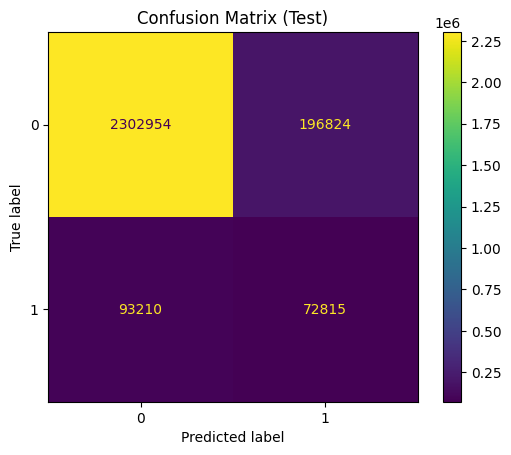

In [91]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(5,5))
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test)")
plt.show()


Shows the raw counts of correct vs incorrect predictions at the chosen threshold (0.159). It breaks predictions into TN, FP, FN, TP, so you can see how many positives the model catches and how many false alarms it produces.

<Figure size 500x500 with 0 Axes>

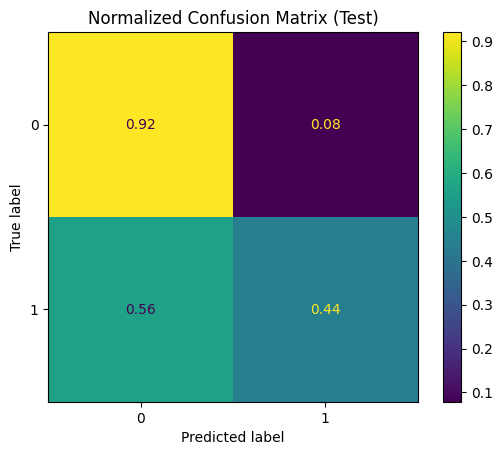

In [92]:
cmn = confusion_matrix(y_test, test_pred, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cmn)

plt.figure(figsize=(5,5))
disp.plot(values_format=".2f")
plt.title("Normalized Confusion Matrix (Test)")
plt.show()


Same as the confusion matrix, but each row is converted to percentages. This makes it easier to interpret performance under imbalance: here it shows the model correctly predicts about 92% of negatives, and captures about 44% of positives (recall), while missing about 56% of positives.

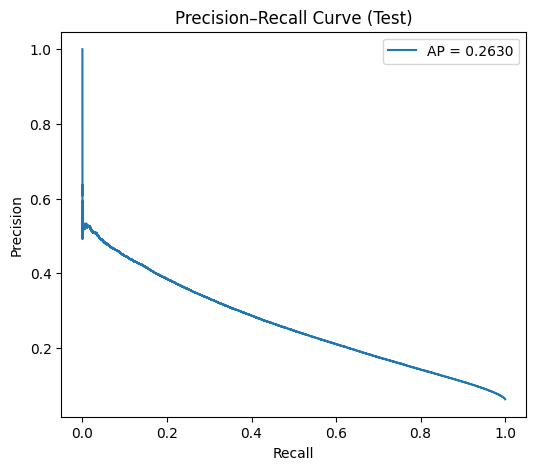

In [90]:
from sklearn.metrics import precision_recall_curve, average_precision_score

prec, rec, _ = precision_recall_curve(y_test, test_proba)
ap = average_precision_score(y_test, test_proba)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test)")
plt.legend()
plt.show()


Plots the trade-off between precision and recall across all thresholds. This is especially important for imbalanced data. The reported AP ≈ 0.263 summarizes the overall PR performance (higher AP means better ranking of true reorders near the top).

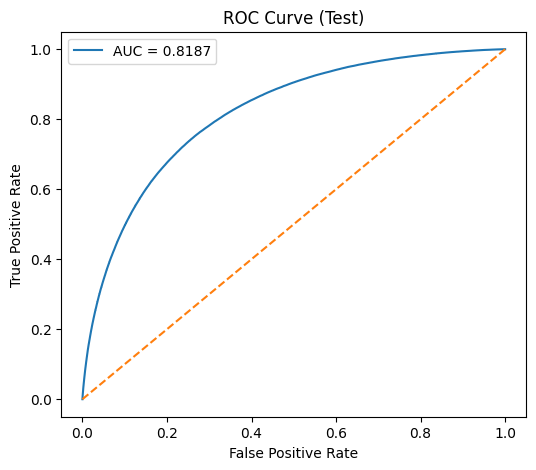

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, test_proba)
auc = roc_auc_score(y_test, test_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()


Plots True Positive Rate vs False Positive Rate across thresholds. The AUC ≈ 0.819 measures overall ranking ability: the curve being well above the diagonal indicates the model separates reorder vs non-reorder substantially better than random.

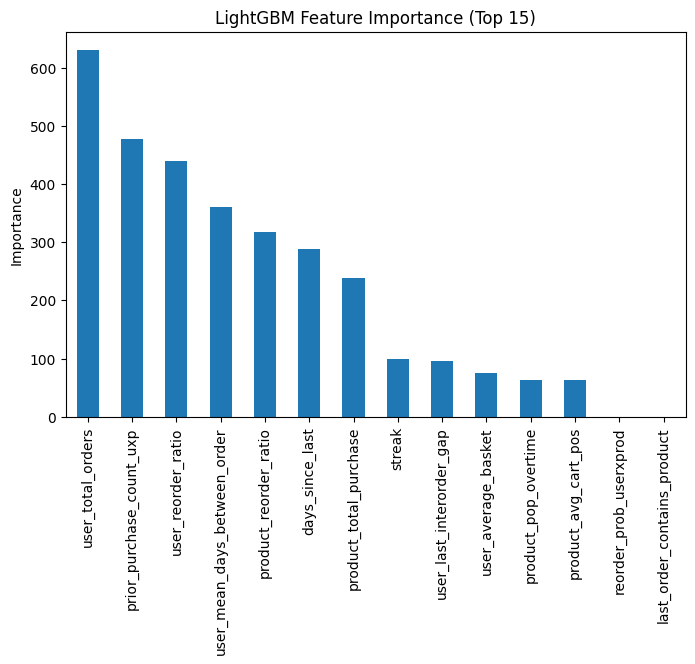

In [93]:
import pandas as pd

imp = pd.Series(final_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
imp.head(15).plot(kind="bar")
plt.title("LightGBM Feature Importance (Top 15)")
plt.ylabel("Importance")
plt.show()


Ranks the most influential features used by the tree model (based on how much they are used to split / improve the model). It highlights which engineered signals drive predictions most—here, user activity features (e.g., user_total_orders) and user–product history (e.g., prior_purchase_count_uxp) appear among the strongest drivers.

Although streak captures strong product-specific reorder behavior, user_total_orders ranks higher in feature importance because it provides a global user-level signal that applies to all samples and is frequently used in early tree splits, whereas streak affects a smaller subset of interactions and is used deeper in the trees.

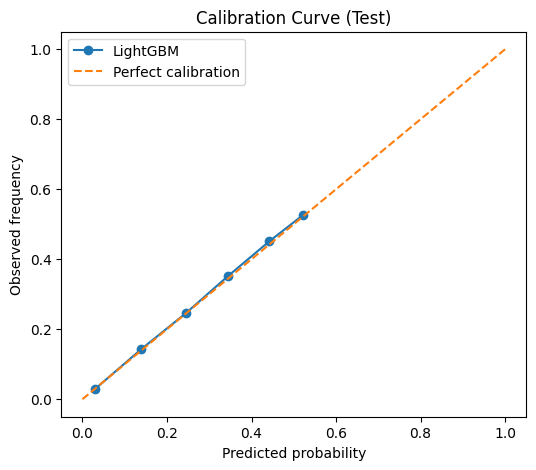

In [94]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(
    y_test, test_proba, n_bins=10, strategy="uniform"
)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="LightGBM")
plt.plot([0,1], [0,1], linestyle="--", label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve (Test)")
plt.legend()
plt.show()


The calibration curve compares predicted probabilities with the observed reorder frequency on the test set. The LightGBM curve lies close to the diagonal, indicating that the predicted probabilities are well calibrated across most probability bins.

This suggests that when the model predicts a certain reorder probability (e.g., 0.2 or 0.4), the true reorder rate in those bins is close to the predicted value. Despite being a tree-based model, LightGBM shows reasonable probability reliability without explicit calibration.

#SHAP

In [95]:
!pip install shap


In [99]:
import shap

In [98]:
explainer = shap.TreeExplainer(final_model)

In [100]:
X_shap = X_test.sample(10000, random_state=42)
shap_values = explainer.shap_values(X_shap)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


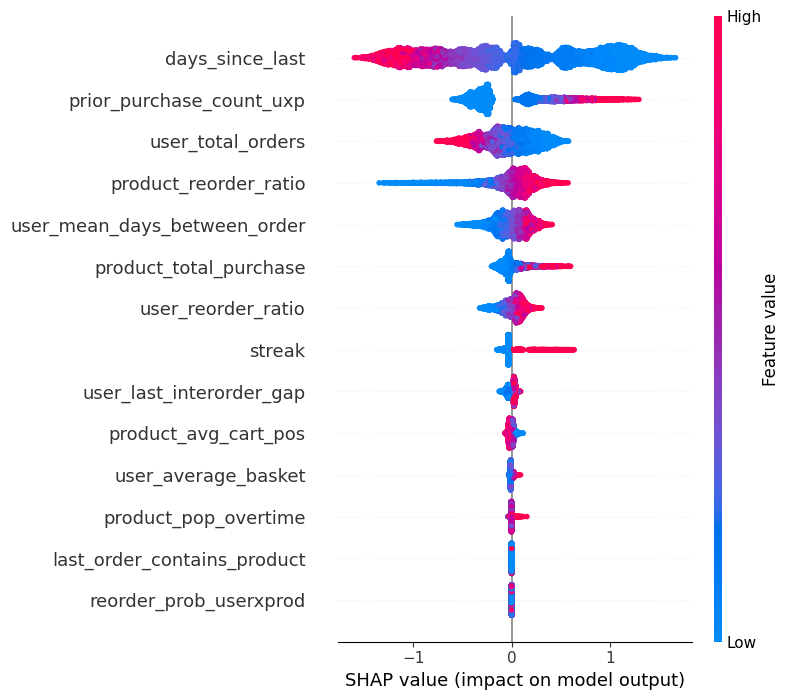

In [101]:
shap.summary_plot(shap_values, X_shap)


Unlike split-based feature importance, SHAP provides both magnitude and direction of feature effects, offering a more reliable and interpretable explanation of model behavior.

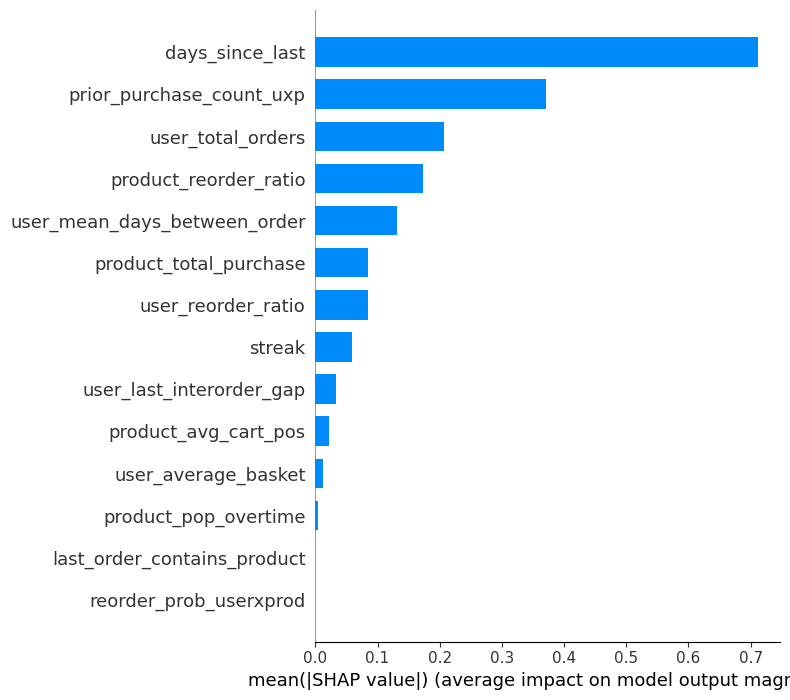

In [102]:
shap.summary_plot(shap_values, X_shap, plot_type="bar")


SHAP analysis was used to interpret the final LightGBM model. The summary plot shows that recency (days_since_last) and user–product interaction features are the strongest drivers of reorder predictions. Feature effects are non-linear and asymmetric, supporting the use of a tree-based model.

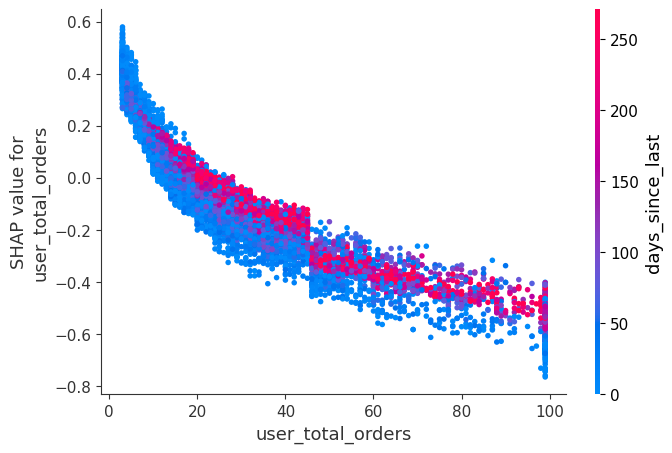

In [103]:
shap.dependence_plot(
    "user_total_orders",
    shap_values,
    X_shap
)


The dependence plot for user_total_orders reveals a decreasing effect on reorder probability as user order count increases, with clear interaction effects from days_since_last. This indicates that recency moderates the impact of overall user activity.

#Final Conclusion — LightGBM Model

In this project, a LightGBM classifier was developed to predict product reorders under a highly imbalanced setting (positive rate ≈ 6%). To avoid data leakage, all model development steps were conducted using GroupKFold cross-validation by user, ensuring that user behavior did not overlap between training and validation folds.

A baseline LightGBM model with early stopping was first established and achieved strong performance. Hyperparameter tuning using randomized search produced only marginal improvements, therefore the baseline configuration was retained for simplicity and stability. Early-stopping behavior observed on a validation sample was used to fix the final number of trees for a single full-training run.

The final model achieved strong generalization performance on the test set, with an AUC of approximately 0.82 and an Average Precision of approximately 0.26, outperforming the logistic regression baseline. A decision threshold was selected using out-of-fold predictions to maximize F1-score, leading to a balanced trade-off between precision and recall.

Model behavior was analyzed using multiple evaluation plots, including ROC, Precision–Recall curves, confusion matrices, and a calibration curve. Results showed that the model not only ranks reorders effectively but also produces reasonably well-calibrated probability estimates.

Finally, SHAP was used to interpret the model. The analysis revealed that recency (days_since_last), user–product interaction history, and user activity level are the strongest drivers of reorder predictions. SHAP dependence plots further demonstrated non-linear effects and feature interactions, justifying the use of a tree-based model over linear approaches.

Overall, LightGBM proved to be a robust and interpretable solution for large-scale reorder prediction, effectively capturing complex behavioral patterns while maintaining strong predictive performance.